# 1) VGG16

In [1]:
from google.colab import drive
import sys
import os
import random
import numpy as np
import cv2

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Setting the Paths

In [2]:
# Get the absolute path of the current folder
abspath_curr = '/content/drive/My Drive/Colab Notebooks/Brain_Tumor/'

# Get the absolute path of the deep utilities folder
abspath_util_deep = '/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/utilities/p3_deep_learning/'

#Test and Train Folders
test_folder = "/content/drive/My Drive/Colab Notebooks/Brain_Tumor/Testing/"
train_folder = "/content/drive/My Drive/Colab Notebooks/Brain_Tumor/Training/"


**Importing Libraries**

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set matplotlib sizes
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

In [4]:
# The magic below allows us to use tensorflow version 2.x
%tensorflow_version 2.x 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
#import tensorflow_datasets as tfds
import numpy as np

**Loading the Data -- ResNet50**

**(a) Setting Parameters**

Note: We tried a bunch of different parameters for ResNet -- these were the ones that ended up working best. See "conclusions" for a complete listing of all parameters tried.

In [5]:
img_size=[224,224]
batch = 32
split = 0.2

epoch_n = 10
random_seed = 42

# Set random seed in tensorflow
tf.random.set_seed(random_seed)

# Set random seed in numpy
np.random.seed(random_seed)

In [6]:
# Change working directory to the absolute path of the deep utilities folder
%cd $abspath_util_deep

# Import the deep utitilities
%run pmlm_utilities_deep.ipynb

/content/drive/My Drive/Colab Notebooks/teaching/gwu/machine_learning_I/fall_2020/code/utilities/p3_deep_learning


**(b) Loading the Data**

In [7]:
data_tr = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=split, subset='training', interpolation='bilinear'
)

data_val = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=split, subset='validation', interpolation='bilinear'
)

data_te = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder, labels='inferred',  class_names=None,
    color_mode='rgb', batch_size=batch, image_size=img_size, seed=random_seed,
    validation_split=None, subset=None, interpolation='bilinear'
)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


**(c) Quick Validations**

In [8]:
#Training Data
class_names_tr = data_tr.class_names
print(class_names_tr)

for images, labels in data_tr.take(1): 
  print(images.shape, labels.shape)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
(32, 224, 224, 3) (32,)


In [9]:
#Validation Data
class_names_val = data_val.class_names
print(class_names_val)

for images, labels in data_val.take(1): 
  print(images.shape, labels.shape)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
(32, 224, 224, 3) (32,)


In [10]:
#Test Data
class_names_te = data_te.class_names
print(class_names_te)

for images, labels in data_te.take(1): 
  print(images.shape, labels.shape)

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
(32, 224, 224, 3) (32,)


**(d) Viewing the Images**

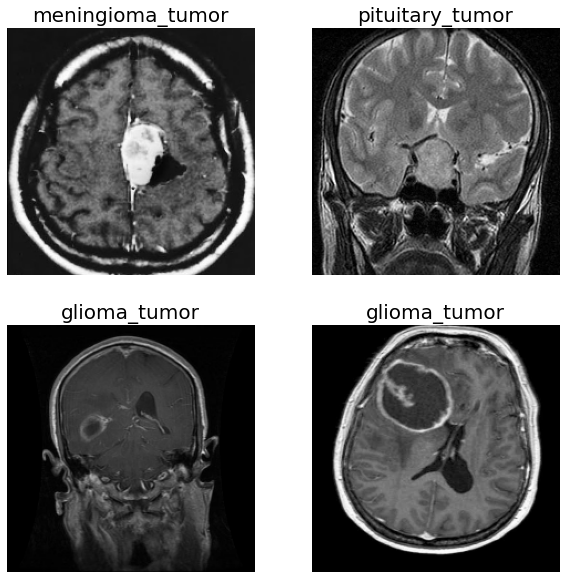

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in data_te.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names_te[labels[i]])
    plt.axis("off")

#4) Using Class Pipeline - VGG16

After loading the data as a tensorflow dataset, we were able to use the pipeline we learned in class.

(a) Preprocessing the Data

In [12]:
# Set the preprocess_input of the pretrained model
global preprocess_input
preprocess_input = tf.keras.applications.resnet.preprocess_input

In [13]:
# Preprocess the training data using pretrained model
data_train = data_tr.map(preprocess_pretrain)

# Preprocess the validation data using pretrained model
data_valid = data_val.map(preprocess_pretrain)

# Preprocess the test data using pretrained model
data_test = data_te.map(preprocess_pretrain)

(b) Creating the Model

In [14]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/VGG16_model/')
if not os.path.exists(directory):
    os.makedirs(directory)

Note: We ended up adding a dropout layer to our model -- we tried different dropout amounts; this one was the value that worked best.  See conclusion for details.

In [15]:
#Loading VGG16 Model

# Add the pretrained layers
pretrained_model = keras.applications.VGG16(include_top=False, weights='imagenet')

# Add GlobalAveragePooling2D layer
average_pooling = keras.layers.GlobalAveragePooling2D()(pretrained_model.output)

# Add Dropout
drop = keras.layers.Dropout(0.5)
dropout = drop(average_pooling)

# Add the output layer
output = keras.layers.Dense(len(class_names_tr), activation='softmax')(dropout)

# Get the model
model = keras.Model(inputs=pretrained_model.input, outputs=output)

#model.summary()

58900480/58889256 [==============================] - 0s 0us/step


**(c) Freeze and Train**

In [16]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Freeze the layer
    layer.trainable = False

In [17]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=abspath_curr + '/result/VGG16_model/model.h5',
                                                      save_best_only=True,
                                                      save_weights_only=True)

# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                                            patience=1)

In [18]:
# Compile the model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',    
              metrics=['accuracy'])

In [ ]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=10,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

Epoch 1/10
72/72 [==============================] - 1463s 20s/step - loss: 5.2121 - accuracy: 0.4734 - val_loss: 3.4569 - val_accuracy: 0.6254 - lr: 0.0100
Epoch 2/10
72/72 [==============================] - 1453s 20s/step - loss: 2.9979 - accuracy: 0.6019 - val_loss: 2.3115 - val_accuracy: 0.5557 - lr: 0.0100
Epoch 3/10
72/72 [==============================] - 1450s 20s/step - loss: 2.5337 - accuracy: 0.6337 - val_loss: 0.9102 - val_accuracy: 0.7822 - lr: 0.0100
Epoch 4/10
72/72 [==============================] - 1439s 20s/step - loss: 2.6614 - accuracy: 0.6529 - val_loss: 2.0292 - val_accuracy: 0.6690 - lr: 0.0100
Epoch 5/10
72/72 [==============================] - ETA: 0s - loss: 1.4837 - accuracy: 0.7291 

**(d) Plotting the Learning Curve**

In [ ]:
# Make directory
directory = os.path.dirname(abspath_curr + '/result/figure/')
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
import pandas as pd

# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_before_unfreezing.pdf')
plt.show()

**(e) Unfreeze the Pretrained Layers and Train again**

In [ ]:
# For each layer in the pretrained model
for layer in pretrained_model.layers:
    # Unfreeze the layer
    layer.trainable = True

Note: We also tried different learning rates -- see conclusion for details.

In [ ]:
# Compile the model
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train, evaluate and save the best model
history = model.fit(data_train,
                    epochs=5,
                    validation_data=data_valid,
                    callbacks=[model_checkpoint_cb,
                               early_stopping_cb,
                               reduce_lr_on_plateau_cb])

**(f) Plotting the Learning Curve and Evaluating the Model**

In [ ]:
# Create a figure
pd.DataFrame(history.history).plot(figsize=(8, 5))

# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.savefig(abspath_curr + '/result/figure/learning_curve_after_unfreezing.pdf')
plt.show()

In [ ]:
# Load the saved model
model.load_weights(filepath=abspath_curr + '/result/VGG16_model/model.h5')

In [ ]:
loss, accuracy = model.evaluate(data_test)